# Python: Average Potential Outcome (APO) Models

In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate average potential outcomes (APOs) in an interactive regression model (see [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#binary-interactive-regression-model-irm)).

The goal is to estimate the average potential outcome

 $$\theta_0 =\mathbb{E}[Y(d)]$$

for a given treatment level $d$ and and discrete valued treatment $D$.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import doubleml as dml
from doubleml.datasets import make_irm_data_discrete_treatments

## Data Generating Process (DGP)

At first, let us generate data according to the [make_irm_data_discrete_treatments](https://docs.doubleml.org/dev/api/generated/doubleml.datasets.make_irm_data_discrete_treatments.html#doubleml.datasets.make_irm_data_discrete_treatments) data generating process. The process generates data with a continuous
treatment variable and contains the true individual treatment effects (ITEs) with respect to option of not getting treated.

According to the continuous treatment variable, the treatment is discretized into multiple levels, based on quantiles. Using the *oracle* ITEs, enables the comparison to the true APOs and averate treatment effects (ATEs) for the different levels of the treatment variable.

**Remark:** The average potential outcome model does not require an underlying continuous treatment variable. The model will work identically if the treatment variable is discrete by design.

In [2]:
# Parameters
n_obs = 3000
n_levels = 5
linear = True
n_rep = 10

np.random.seed(42)
data_apo = make_irm_data_discrete_treatments(n_obs=n_obs,n_levels=n_levels, linear=linear)

y0 = data_apo['oracle_values']['y0']
cont_d = data_apo['oracle_values']['cont_d']
ite = data_apo['oracle_values']['ite']
d = data_apo['d']
potential_level = data_apo['oracle_values']['potential_level']
level_bounds = data_apo['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i]) * (i > 0)
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average Individual effects in each group:\n{np.round(average_ites,2)}\n")
print(f"Average Potential Outcomes in each group:\n{np.round(apos,2)}\n")
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

Average Individual effects in each group:
[ 0.    1.75  7.03  9.43 10.4  10.49]

Average Potential Outcomes in each group:
[210.04 211.79 217.06 219.47 220.44 220.53]

Levels and their counts:
(array([0., 1., 2., 3., 4., 5.]), array([615, 487, 465, 482, 480, 471]))


To better grasp the distribution of the treatment effects, let us plot the true APOs and ATEs.

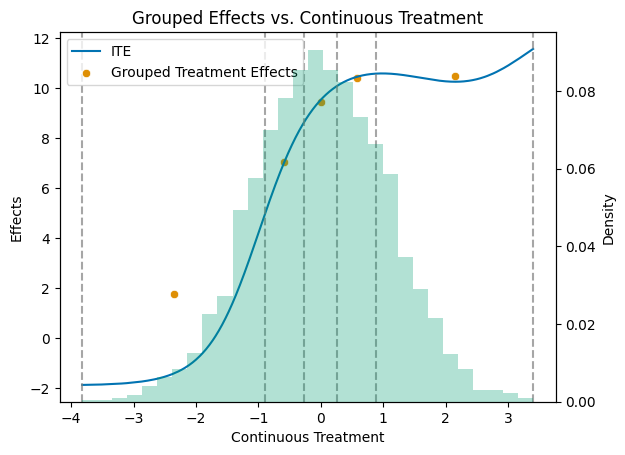

In [3]:
# Get a colorblind-friendly palette
palette = sns.color_palette("colorblind")

df = pd.DataFrame({'cont_d': cont_d, 'ite': ite})
df_sorted = df.sort_values('cont_d')

mid_points = np.full(n_levels, np.nan)
for i in range(n_levels):
    mid_points[i] = (level_bounds[i] + level_bounds[i + 1]) / 2

df_apos = pd.DataFrame({'mid_points': mid_points, 'treatment effects': apos[1:] - apos[0]})

# Create the primary plot with scatter and line plots
fig, ax1 = plt.subplots()

sns.lineplot(data=df_sorted, x='cont_d', y='ite', color=palette[0], label='ITE', ax=ax1)
sns.scatterplot(data=df_apos, x='mid_points', y='treatment effects', color=palette[1], label='Grouped Treatment Effects', ax=ax1)

# Add vertical dashed lines at level_bounds
for bound in level_bounds:
    ax1.axvline(x=bound, color='grey', linestyle='--', alpha=0.7)

ax1.set_title('Grouped Effects vs. Continuous Treatment')
ax1.set_xlabel('Continuous Treatment')
ax1.set_ylabel('Effects')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram on the secondary y-axis
ax2.hist(df_sorted['cont_d'], bins=30, alpha=0.3, weights=np.ones_like(df_sorted['cont_d']) / len(df_sorted['cont_d']), color=palette[2])
ax2.set_ylabel('Density')

# Make sure the legend includes all plots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.show()

As for all [DoubleML](https://docs.doubleml.org/stable/index.html) models, we specify a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.data.DoubleMLData.html) object to handle the data.

In [4]:
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = dml.DoubleMLData(df_apo, 'y', 'd')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x0', 'x1', 'x2', 'x3', 'x4']
Instrument variable(s): None
No. Observations: 3000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 7 entries, y to x4
dtypes: float64(7)
memory usage: 164.2 KB



## Single Average Potential Outcome Models (APO)

Further, we have to specify machine learning algorithms. As in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-models-irm) model, we have to set ``ml_m`` as a classifier and ``ml_g`` as a regressor (since the outcome is continuous). As in the 
[DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-models-irm) model, the classifier ``ml_m`` is used to estimate the conditional probability of receiving treatment level $d$ given the covariates $X$

$$m_{0,d}(X) = \mathbb{E}[1\{D=d\}|X]$$

and the regressor ``ml_g`` is used to estimate the conditional expectation of the outcome $Y$ given the covariates $X$ and the treatment $D$

$$g_{0}(D, X) = \mathbb{E}[Y|X,D].$$

As the DGP is linear we will use a linear regression model for the regressor and a logistic regression model for the classifier.

In [5]:
ml_g = LinearRegression()
ml_m = LogisticRegression()

Further, the [DoubleMLAPO](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPO.html) model requires a specification of the treatment level $a$ for which the APOs should be estimated. In this example, we will loop over all treatment levels.

In [6]:
np.random.seed(42)

treatment_levels = np.unique(d)
thetas = np.full(n_levels + 1, np.nan)
ci = np.full((n_levels + 1, 2), np.nan)

for i_level, treatment_level in enumerate(treatment_levels):
    dml_obj = dml.DoubleMLAPO(
        dml_data,
        ml_g,
        ml_m,
        treatment_level=treatment_level,
        n_rep=n_rep,
    )

    dml_obj.fit()

    thetas[i_level] = dml_obj.coef[0]
    ci[i_level, :] = dml_obj.confint(level=0.95).values

# combine results
df_apo_ci = pd.DataFrame(
    {'treatment_level': treatment_levels,
     'apo': apos,
     'theta': thetas,
     'ci_lower': ci[:, 0],
     'ci_upper': ci[:, 1]}
)

df_apo_ci

treatment_level         apo       theta    ci_lower    ci_upper
0              0.0  210.036240  210.077702  208.768798  211.386831
1              1.0  211.785815  211.881937  210.545492  213.218383
2              2.0  217.063017  217.069443  215.750701  218.388185
3              3.0  219.468907  219.404300  218.096418  220.712095
4              4.0  220.439699  220.503700  219.186589  221.820963
5              5.0  220.525064  220.417834  219.095104  221.740505

The tables above displays the estimated values in the ``theta`` column and the corresponding oracle values in the ``apo`` column. 

Again, let us summarize the results in a plot of the APOs with confidence intervals.

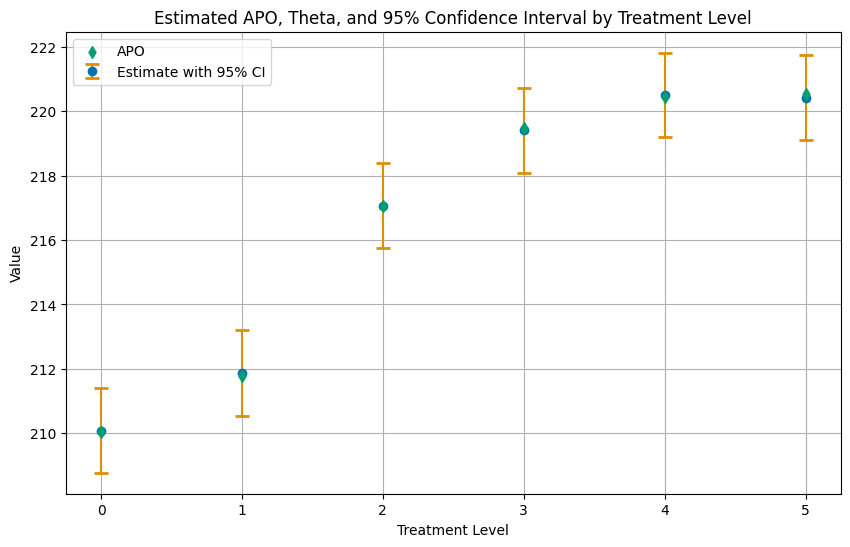

In [7]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_apo_ci['treatment_level'], df_apo_ci['theta'], 
             yerr=[df_apo_ci['theta'] - df_apo_ci['ci_lower'], df_apo_ci['ci_upper'] - df_apo_ci['theta']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apo_ci['treatment_level'], df_apo_ci['apo'], color=palette[2], label='APO', marker='d', zorder=3)

plt.title('Estimated APO, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apo_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

## Multiple Average Potential Outcome Models (APOS)

Instead of looping over different treatment levels, one can directly use the [DoubleMLAPOS](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPOS.html#doubleml.irm.DoubleMLAPOS) model which internally combines multiple [DoubleMLAPO](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPO.html) models. An advantage of this approach is that the model can be parallelized, create joint confidence intervals and allow for a comparison between the average potential outcome levels.

### Average Potential Outcome (APOs)

As before, we just have to specify the machine learning algorithms and the treatment levels for which the APOs should be estimated.

In [8]:
dml_obj = dml.DoubleMLAPOS(
    dml_data,
    ml_g,
    ml_m,
    treatment_levels=treatment_levels,
    n_rep=n_rep,
)

dml_obj.fit()

ci_pointwise = dml_obj.confint(level=0.95)

df_apos_ci = pd.DataFrame(
    {'treatment_level': treatment_levels,
     'apo': apos,
     'theta': thetas,
     'ci_lower': ci_pointwise.values[:, 0],
     'ci_upper': ci_pointwise.values[:, 1]}
)

df_apos_ci

treatment_level         apo       theta    ci_lower    ci_upper
0              0.0  210.036240  210.077702  208.766940  211.384677
1              1.0  211.785815  211.881937  210.553004  213.225427
2              2.0  217.063017  217.069443  215.756200  218.393654
3              3.0  219.468907  219.404300  218.108259  220.723846
4              4.0  220.439699  220.503700  219.192952  221.828157
5              5.0  220.525064  220.417834  219.095785  221.741523

Again, let us summarize the results in a plot.

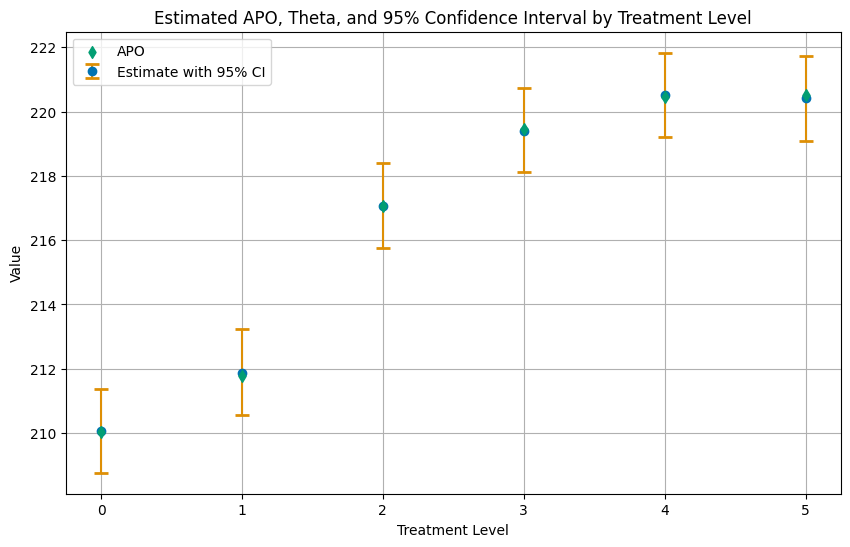

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_apos_ci['treatment_level'], df_apos_ci['theta'], 
             yerr=[df_apos_ci['theta'] - df_apos_ci['ci_lower'], df_apos_ci['ci_upper'] - df_apos_ci['theta']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apos_ci['treatment_level'], df_apos_ci['apo'], color=palette[2], label='APO', marker='d', zorder=3)

plt.title('Estimated APO, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apos_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

For joint confidence intervals, the ``bootstrap`` method can be used.

In [10]:
dml_obj.bootstrap(n_rep_boot=2000)
ci_joint = dml_obj.confint(level=0.95, joint=True)

ci_joint

2.5 %      97.5 %
0.0  208.642329  211.518478
1.0  210.419871  213.355065
2.0  215.622272  218.521233
3.0  217.975289  220.850038
4.0  219.058375  221.962364
5.0  218.968127  221.878746

## Sensitivity Analysis

For [DoubleMLAPO](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPO.html) and [DoubleMLAPOS](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPOS.html#doubleml.irm.DoubleMLAPOS) model all methods for sensitivity analysis are available.

In [11]:
dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
     CI lower  theta lower       theta  theta upper    CI upper
0  208.792396   209.890855  210.075809   210.260762  211.359229
1  210.543052   211.663177  211.889638   212.115901  213.238619
2  215.752696   216.858952  217.074927   217.290901  218.398166
3  218.114989   219.212811  219.416052   219.619294  220.716615
4  219.189739   220.296099  220.510555   220.725010  221.830273
5  219.072605   220.184224  220.418741   220.652324  221.761224

------------------ Robustness Values ------------------
   H_0     RV (%)    RVa (%)
0  0.0  99.916359  99.909571
1  0.0  99.877903  99.861019
2  0.0  99.893461  99.882928
3  0.0  99.907879  99.899250
4  0.0  99.898183  99.888352
5  0.0  99.878895  99.864664


Additionally, ``sensitvity_benchmark`` can be used. In this example we benchmark covariate ``x4`` which does not affect treatment $D$ or outcome $Y$.

In [12]:
dml_obj.sensitivity_benchmark(benchmarking_set=['x4'])

cf_y      cf_d  rho  delta_theta
0.0   0.0  0.000000  0.0     0.000006
1.0   0.0  0.000000 -1.0    -0.004253
2.0   0.0  0.000000  1.0     0.003220
3.0   0.0  0.000000 -1.0    -0.004526
4.0   0.0  0.003415  1.0     0.003404
5.0   0.0  0.000000 -1.0    -0.006055

 For more details on the sensitivity analysis, please refer to the [User Guide](https://docs.doubleml.org/stable/guide/sensitivity.html).

### Causal Contrasts

The [DoubleMLAPOS](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPOS.html#doubleml.irm.DoubleMLAPOS) model also allows for the estimation of causal contrasts. 
The contrast is defined as the difference in the average potential outcomes between the treatment levels $d_i$ and $d_j$ where

$$ \theta_{0,ij} = \mathbb{E}[Y(d_i)] - \mathbb{E}[Y(d_{j})]$$

and will be calculated for all defined treatment levels $i$ and reference levels $j$.

In this example, we will estimate the causal contrast between the treatment level $0$ and all other treatment levels, as the treatment level $0$ corresponds to no treatment at all whereas the the other levels are based on the treatment dosage.

Therefore we have to specify ``reference_levels=0``.

In [13]:
causal_contrast_model = dml_obj.causal_contrast(reference_levels=0)
print(causal_contrast_model.summary)

                 coef   std err          t  P>|t|      2.5 %     97.5 %
1.0 vs 0.0   1.810306  0.180143  10.049264    0.0   1.454406   2.165707
2.0 vs 0.0   6.994208  0.145027  48.226969    0.0   6.710059   7.278035
3.0 vs 0.0   9.335446  0.135344  68.975592    0.0   9.068934   9.600776
4.0 vs 0.0  10.431998  0.141460  73.745022    0.0  10.155160  10.708837
5.0 vs 0.0  10.342362  0.155174  66.650234    0.0  10.039141  10.645583


Finally, let us summarize the results in a plot.

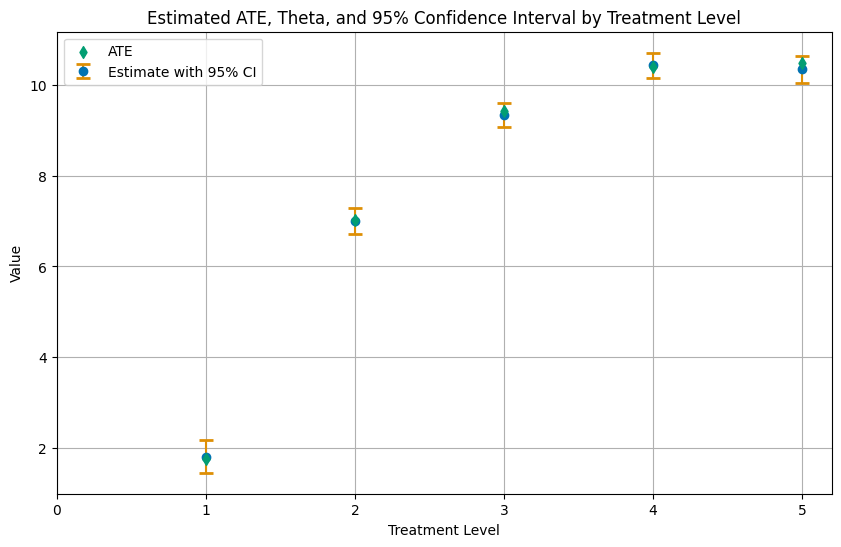

In [14]:
ates = causal_contrast_model.thetas
ci_ates = causal_contrast_model.confint(level=0.95)

df_ates = pd.DataFrame(
    {'treatment_level': treatment_levels[1:],
     'ate': ates,
     'ci_lower': ci_ates.iloc[:, 0].values,
     'ci_upper': ci_ates.iloc[:, 1].values}
)

# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_ates['treatment_level'], df_ates['ate'],
             yerr=[df_ates['ate'] - df_ates['ci_lower'], df_ates['ci_upper'] - df_ates['ate']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apos_ci['treatment_level'][1:], average_ites[1:], color=palette[2], label='ATE', marker='d', zorder=3)

plt.title('Estimated ATE, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apos_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

The methods ``sensitivity_analysis`` and ``sensitivity_plot`` are also available for the causal contrasts.

In [15]:
causal_contrast_model.sensitivity_analysis()
print(causal_contrast_model.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
            CI lower  theta lower      theta  theta upper   CI upper
1.0 vs 0.0  1.219585     1.518854   1.810306     2.101998   2.400905
2.0 vs 0.0  6.469676     6.708821   6.994208     7.279595   7.517798
3.0 vs 0.0  8.835344     9.060016   9.335446     9.610318   9.833065
4.0 vs 0.0  9.914598    10.148005  10.431998    10.716098  10.947855
5.0 vs 0.0  9.786986    10.040784  10.342362    10.643939  10.899654

------------------ Robustness Values ------------------
            H_0     RV (%)    RVa (%)
1.0 vs 0.0  0.0  17.204893  14.534139
2.0 vs 0.0  0.0  51.844663  50.155423
3.0 vs 0.0  0.0  62.924443  61.490896
4.0 vs 0.0  0.0  65.700314  64.285001
5.0 vs 0.0  0.0  63.327958  61.784872


As an example see the ``sensitivity_plot`` for the first causal contrast ``1.0 vs 0.0``.

In [16]:
causal_contrast_model.sensitivity_plot(idx_treatment=0)

Benchmarking is not available for causal contrasts.